# Chinese text summarization algorithm
### www.KudosData.com
#### By: Sam GU Zhan
#### March, 2017

# Imports

In [1]:
# coding=UTF-8
from __future__ import division
import re

# Python2 unicode & float-division support:
# from __future__ import unicode_literals, division

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import io

# 中文字符和语言处理库
import jieba

# 机器学习库 sklearn 分类学习模型库
#from sklearn import linear_model
from sklearn.feature_extraction import DictVectorizer # 数据结构变换：把 Dict 转换为 稀疏矩阵
# from sklearn.linear_model import LogisticRegression  # 逻辑回归分类模型
# from sklearn.pipeline import make_pipeline # 封装机器学习模型流程
# from sklearn.metrics import confusion_matrix, roc_curve, auc

# 中文显示设置
from pylab import *  
mpl.rcParams['font.sans-serif'] = ['SimHei'] # 指定默认字体  
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题 
mpl.rcParams['font.size'] = 14 # 设置字体大小

np.random.seed(88)

# Define Functions

In [3]:
# Python3
# 中文分词功能小函数， 输出 字符串， 各词组由空格分隔
def KudosData_word_tokenizer(foo):
    # remove lead & tail spaces firstly:
    foo = foo.strip()
    seg_token = jieba.cut(str(foo), cut_all=True)
    seg_str = str(' '.join(seg_token)).strip()

    return seg_str
# Python2
# 中文分词功能小函数， 输出 字符串， 各词组由空格分隔
# def KudosData_word_tokenizer(foo):
#     seg_token = jieba.cut(foo, cut_all=True)
#     seg_str = ' '.join(seg_token)
#     return seg_str

In [4]:
# Python3
# 中文分词功能小函数， 输出 dictionary： { key 词组， value 计数 }
def KudosData_word_count(foo):
    # remove lead & tail spaces firstly:
    foo = foo.strip()
    seg_token = jieba.cut(str(foo), cut_all=True)
    seg_str = str(' '.join(seg_token)).strip()
    seg_count = pd.value_counts(str(seg_str).lower().split(' '))
    seg_count = seg_count.to_dict() 
    seg_count.pop('', None) # remove EMPTY dict key: ''
    return seg_count
# Python2
# 中文分词功能小函数， 输出 dictionary： { key 词组， value 计数 }
# def KudosData_word_count(foo):
#     seg_token = jieba.cut(foo, cut_all=True)
#     seg_str = '^'.join(seg_token)
#     seg_count = pd.value_counts(seg_str.lower().split('^'))
#     return seg_count.to_dict()

# Input text

In [5]:
# process Unicode text input
with io.open('input_text.txt','r',encoding='utf8') as f:
    text = f.read()

content = text

title = '''
<Dummy Title>
'''

In [6]:
# content

In [7]:
def format_sentence(text):
#     sentence = re.sub(r'\W+', '#', sentence)
    text = re.sub(r'\t+', '', text) # remove one or more Tab
    return text

In [8]:
def extract_valid_sentence_words(text):
    text = re.sub(r'\W+', '#', text.strip())
    return text

In [9]:
def linebreak_conversion_win_linux(text):
    text = re.sub(r'\r', '', text) # remove one or more Tab
    text = re.sub(r'\u3000', ' ', text) # convert white space: \u3000    
    return text

In [10]:
def clean_some_whitespace(text): # Does not remove normal Space
#     sentence = re.sub(r'\W+', '#', sentence)
    text = re.sub(r'\t+', '', text) # remove one or more Tab
    text = re.sub(r'\f+', '', text) # remove one or more
    text = re.sub(r'\v+', '', text) # remove one or more
    text = re.sub(r'\n+', '', text) # remove one or more \n, this is to merge sentences within paragraph

    text = re.sub(r'(\^\*\#)( +)(\#\*\^)', '^*##*^', text) # remove one or more Spaces between Paragraph-Tags or Sentence-Tags

    text = re.sub(r' +', ' ', text) # merge two or more Spaces to 1 Space

    # remove lead & tail spaces:
    text =text.strip()

#     text = re.sub(r'( +)\W', r'\W', text) # remove Spaces before special char
#     text = re.sub(r'\W( +)', r'\W', text) # remove Spaces after special char
    
    return text

In [11]:
### Define Paragraph-Tag =  
#   #*^P^*#

### Define Sentence-Tag =  
#   #*^S^*#


In [12]:
# add a special tage to end of each paragraph
def tag_paragraph(text):
    text = re.sub(r'((\n ) +)+', '#*^P^*#', text) # Tag paragraph, pattern: \n + two or more Spaces
    text = re.sub(r'((\n\t) +)+', '#*^P^*#', text) # Tag paragraph, pattern: \n + two or more Tabs
    text = re.sub(r'(\n( *)\n)+', '#*^P^*#', text) # Tag paragraph, pattern: \n + zero or more Spaces + \n
    text = re.sub(r'(\#\*\^P\^\*\#)+', '#*^P^*#', text) # merge two or more Paragraph-Tags -> 1 Paragraph-Tag

    return text

In [13]:
# add a special tage to end of each sentence
def tag_sentence(text):
    text = re.sub(r'。+', '。#*^S^*#', text) # Tag sentence - Chinese
    text = re.sub(r'！+', '！#*^S^*#', text) # Tag sentence - Chinese
    text = re.sub(r'\？+', '？#*^S^*#', text) # Tag sentence - Chinese
    text = re.sub(r'；+', '；#*^S^*#', text) # Tag sentence - Chinese

    text = re.sub(r'!+', '!#*^S^*#', text) # Tag sentence - English
    text = re.sub(r'\?+', '?#*^S^*#', text) # Tag sentence - English
    text = re.sub(r';+', ';#*^S^*#', text) # Tag sentence - English
   
    # merge two or more sentence-Tags -> 1 Sentence-Tag
    text = re.sub(r'(\W?(\#\*\^S\^\*\#))+', '。#*^S^*#', text)

    # remove a Sentence-Tag immediately before an ending ”
    text = re.sub(r'\#\*\^S\^\*\#”', '”', text) 
    
    # remove a Sentence-Tag immediately before a Paragraph-Tag
    text = re.sub(r'(\#\*\^S\^\*\#)( *)(\#\*\^P\^\*\#)', '#*^P^*#', text) 
    
    text = re.sub(r'(\#\*\^P\^\*\#)+', '#*^P^*#', text) # merge two or more Paragraph-Tags -> 1 Paragraph-Tag

    
    return text

### Start tagging:

In [14]:
content_format = linebreak_conversion_win_linux(content)
# content_format

In [15]:
content_format = tag_paragraph(content_format)
# content_format

In [16]:
content_format = clean_some_whitespace(content_format)
# content_format

In [17]:
content_format = tag_sentence(content_format)
# content_format

In [18]:
content_format = clean_some_whitespace(content_format)
content_format

'《黄金时代》王小波#*^P^*#一 #*^P^*#我二十一岁时，正在云南插队。#*^S^*#陈清扬当时二十六岁，就在我插队的地方当医生。#*^S^*#我在山下十四队，她在山上十五队。#*^S^*#有一天她从山上下来，和我讨论她不是破鞋的问题。#*^S^*#那时我还不大认识她，只能说有一点知道。#*^S^*#她要讨论的事是这祥的：虽然所有的人都说她是一个破鞋，但她以为自己不是的。#*^S^*#因为破鞋偷汉，而她没有愉过汉。#*^S^*#虽然她丈夫已经住了一年监狱，但她没有偷过汉。#*^S^*#在此之前也未偷过汉。#*^S^*#所以她简直不明白，人们为什么要说她是破鞋。#*^S^*#如果我要安慰她，并不困难。#*^S^*#我可以从逻辑上证明她不是破鞋。#*^S^*#如果陈清扬是破鞋，即陈清扬偷汉，则起码有一个某人为其所偷。#*^S^*#如今不能指出某人，所以陈清扬偷汉不能成立。#*^S^*#但是我偏说，陈清扬就是破鞋，而且这一点毋庸置疑。#*^P^*#陈清扬找我证明她不是破鞋，起因是我找她打针。#*^S^*#这事经过如下：农忙时队长不叫我犁田，而是叫我去插秧，这样我的腰就不能经常直立，认识我的人都知道，我的腰上有旧伤，而且我身高在一米九以上。#*^S^*#如此插了一个月，我腰痛难忍，不打封闭就不能入睡。#*^S^*#我们队医务室那一把针头镀层剥落，而且都有倒钩，经常把我腰上的肉钩下来。#*^S^*#后来我的腰就像中了散弹枪，伤痕久久不褪。#*^S^*#就在这种情况下，我想起十五队的队医陈清扬是北医大毕业的大夫，对针头和勾针大概还能分清，所以我去找她看病，看完病回来，不到半个小时，她就追到我屋里来，要我证明她不是破鞋。#*^P^*#陈清扬说，她丝毫也不藐视破鞋。#*^S^*#据她观察，破鞋都很善良，乐于助人，而且最不乐意让人失望。#*^S^*#因此她对破鞋还有一点钦佩。#*^S^*#问题不在于破鞋好不好，而在于她根本不是破鞋。#*^S^*#就如一只猫不是一只狗一样。#*^S^*#假如一只猫被人叫成一只狗，它也会感到很不自在。#*^S^*#现在大家都管她叫被鞋，弄得她魂不守舍，几乎连自己是谁都不知道了。#*^P^*#陈清扬在我的草房里时，裸臂赤腿穿一件白大褂，和她在山上那间医务室里装束一样，所不同的是披散的长发用个手绢束住，脚上也多了一双拖鞋。#*^S^*#看了她的样子，


### Transfer tagged text to Pandas Dataframe

In [19]:
# Split a text into paragraphs
def split_article_to_paragraphs(text):
#     text = text.replace("#*^P^*#", "#*^S^*#") # convert Paragraph-Tag        
    return text.split("#*^P^*#")


In [20]:
# Split a paragraph into sentences
def split_paragraph_to_sentences(text):
#     text = text.replace("#*^P^*#", "#*^S^*#") # convert Paragraph-Tag        
    return text.split("#*^S^*#")


In [21]:
# 1st loop Paragraphs list, 2nd loop Sentences list
# create a few new columns, then write into dataframe, together with original Sentence string

# define empty dataframe:
df_article = pd.DataFrame(columns=('sentence', 
                                   'word_count', # sentence word count, including punctuations 
                                   'sentence_id', # unique sentence s/n within an article
                                   'sentence_id_paragraph',  # sentence s/n within a paragraph 
                                   'paragraph_id', 
                                   'class_rank', 
                                   'score_word', # score based on word tf-idf
                                   'score_sentence', # score based on intersection of sentence pairs
                                   'score_word_norm', # Normalized score
                                   'score_sentence_norm', # Normalized score
                                   'score',
                                  ))
df_sentence_id = 0

# split_article_to_paragraphs:
article_paragraphs = split_article_to_paragraphs(content_format)

for i in range(0, len(article_paragraphs)):
    # split_paragraph_to_sentences:
    article_paragraphs_sentences = split_paragraph_to_sentences(article_paragraphs[i].strip())

    for j in range(0, len(article_paragraphs_sentences)):
        if article_paragraphs_sentences[j].strip() != '':
            df_sentence_id = df_sentence_id + 1
            # write to dataframe:
            df_article.loc[len(df_article)] = [article_paragraphs_sentences[j].strip(), 
                                               len(article_paragraphs_sentences[j].strip()), 
                                               df_sentence_id, 
                                               j+1, 
                                               i+1, 
                                               '', 
                                               '', 
                                               '', 
                                               '', 
                                               '', 
                                               '']


In [22]:
# Make sure no empty sentences:
print('Number of empty sentences in dataframe: %d ' % len(df_article[df_article['sentence'] == '']))

Number of empty sentences in dataframe: 0 


In [23]:
df_article

,sentence,word_count,sentence_id,sentence_id_paragraph,paragraph_id,class_rank,score_word,score_sentence,score_word_norm,score_sentence_norm,score
0,《黄金时代》王小波,9,1,1,1,,,,,,
1,一,1,2,1,2,,,,,,
2,我二十一岁时，正在云南插队。,14,3,1,3,,,,,,
3,陈清扬当时二十六岁，就在我插队的地方当医生。,22,4,2,3,,,,,,
4,我在山下十四队，她在山上十五队。,16,5,3,3,,,,,,
5,有一天她从山上下来，和我讨论她不是破鞋的问题。,23,6,4,3,,,,,,
6,那时我还不大认识她，只能说有一点知道。,19,7,5,3,,,,,,
7,她要讨论的事是这祥的：虽然所有的人都说她是一个破鞋，但她以为自己不是的。,36,8,6,3,,,,,,
8,因为破鞋偷汉，而她没有愉过汉。,15,9,7,3,,,,,,
9,虽然她丈夫已经住了一年监狱，但她没有偷过汉。,22,10,8,3,,,,,,


In [24]:
# count number of sentences within a paragraph_ids
# This can identify paragraph(s) with single sentence, which may be removed.
df_article['paragraph_id'].value_counts()


111    22
84     19
6      17
151    17
60     16
88     16
93     16
33     15
51     15
124    15
110    15
3      15
69     14
172    14
86     14
103    13
185    13
10     13
52     13
20     13
132    13
126    13
204    13
96     13
133    12
75     12
55     12
116    12
174    12
100    12
       ..
153     2
22      2
155     2
25      2
28      2
212     2
167     2
205     2
106     2
34      2
12      2
182     2
44      2
2       1
15      1
213     1
21      1
29      1
46      1
68      1
83      1
95      1
118     1
141     1
146     1
158     1
168     1
184     1
200     1
1       1
Name: paragraph_id, dtype: int64

### Calculate importance score for each sentence

### [Optional Reference] word_tokenizer

In [25]:
# KudosData_word_tokenizer
df_article['sentence_tokenized'] = df_article['sentence'].apply(lambda x: KudosData_word_tokenizer(x))

Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\TELESC~1\AppData\Local\Temp\jieba.cache
DEBUG:jieba:Loading model from cache C:\Users\TELESC~1\AppData\Local\Temp\jieba.cache
Loading model cost 1.772 seconds.
DEBUG:jieba:Loading model cost 1.772 seconds.
Prefix dict has been built succesfully.
DEBUG:jieba:Prefix dict has been built succesfully.


### [Optional Reference] Term Frequency

In [26]:
# KudosData_word_count
df_article['sentence_tf'] = df_article['sentence'].apply(lambda x: KudosData_word_count(x))

### [Optional Reference] TF-IDF

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
corpus = df_article['sentence_tokenized']

vectorizer = TfidfVectorizer()

# my_stopword_list = ['and','to','the','of', 'in']
#vectorizer = TfidfVectorizer(stop_words=my_stopword_list)

# choice of no nomalization of tfidf output (not recommended)
#vectorizer = TfidfVectorizer(norm=None)

# TF-IDF score
tfidf = vectorizer.fit_transform(corpus)

# IDF score
idf_dict = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))

# TF is in df_article[['sentence_tf']]

In [28]:
### 把TF-iDF数值赋予相对应的词组
tfidf = tfidf.tocsr()

n_docs = tfidf.shape[0]
tfidftables = [{} for _ in range(n_docs)]
terms = vectorizer.get_feature_names()

for i, j in zip(*tfidf.nonzero()):
    tfidftables[i][terms[j]] = tfidf[i, j]

In [29]:
# Document-Term-Matrix's TF-IDF matrix size:
print ('This tfidf matrix is a very large table: [ %d rows/docs X %d columns/words ]' 
       % (tfidf.shape[0], tfidf.shape[1]))
print ('It contains %d eliments: one score per word per document !'
       % (tfidf.shape[0] * tfidf.shape[1]))

This tfidf matrix is a very large table: [ 1456 rows/docs X 3955 columns/words ]
It contains 5758480 eliments: one score per word per document !


In [30]:
# Add tfidf score into dataframe 
df_article['tfidf'] = tfidftables

In [31]:
# df_article[['sentence', 'sentence_tokenized', 'tfidf']].head()
df_article[['sentence', 'sentence_tokenized', 'sentence_tf', 'tfidf']]

,sentence,sentence_tokenized,sentence_tf,tfidf
0,《黄金时代》王小波,黄金 黄金时代 时代 王小波 小波,"{'小波': 1, '王小波': 1, '黄金时代': 1, '时代': 1, '黄金': 1}","{'时代': 0.417605484371, '小波': 0.488270917765, '..."
1,一,一,{'一': 1},{}
2,我二十一岁时，正在云南插队。,我 二十 二十一 二十一岁 十一 十一岁 一岁 时 正在 云南 插队,"{'十一岁': 1, '二十': 1, '插队': 1, '时': 1, '正在': 1, ...","{'十一岁': 0.334452413499, '一岁': 0.334452413499, ..."
3,陈清扬当时二十六岁，就在我插队的地方当医生。,陈 清扬 当时 二十 二十六 二十六岁 十六 十六岁 六岁 就 在 我 插队 的 地方 ...,"{'二十': 1, '陈': 1, '插队': 1, '就': 1, '二十六': 1, '...","{'医生': 0.328206885656, '二十六岁': 0.346726964056,..."
4,我在山下十四队，她在山上十五队。,我 在 山下 十四 四队 她 在 山上 十五 五队,"{'五队': 1, '她': 1, '我': 1, '十四': 1, '十五': 1, '山...","{'五队': 0.365009675053, '十五': 0.361182180159, '..."
5,有一天她从山上下来，和我讨论她不是破鞋的问题。,有 一天 她 从 山上 上下 下来 和 我 讨论 她 不是 破鞋 的 问题,"{'破鞋': 1, '问题': 1, '上下': 1, '山上': 1, '有': 1, '...","{'破鞋': 0.273997396576, '问题': 0.338960686611, '..."
6,那时我还不大认识她，只能说有一点知道。,那时 我 还 不大 认识 她 只能 说 有 一点 知道,"{'还': 1, '说': 1, '知道': 1, '有': 1, '不大': 1, '一点...","{'那时': 0.331227409775, '知道': 0.345408617664, '..."
7,她要讨论的事是这祥的：虽然所有的人都说她是一个破鞋，但她以为自己不是的。,她 要 讨论 的 事 是 这 祥 的 虽然 所有 的 人 都 说 她 是 一个 破鞋 ...,"{'破鞋': 1, '虽然': 1, '人': 1, '所有': 1, '是': 2, '都...","{'破鞋': 0.273442656961, '自己': 0.308576860009, '..."
8,因为破鞋偷汉，而她没有愉过汉。,因为 破鞋 偷 汉 而 她 没有 愉 过 汉,"{'过': 1, '愉': 1, '偷': 1, '她': 1, '汉': 2, '因为':...","{'破鞋': 0.559203184229, '因为': 0.599879892089, '..."
9,虽然她丈夫已经住了一年监狱，但她没有偷过汉。,虽然 她 丈夫 已经 住 了 一年 监狱 但 她 没有 偷 过 汉,"{'一年': 1, '丈夫': 1, '住': 1, '已经': 1, '了': 1, '但...","{'一年': 0.49871963512, '丈夫': 0.472081018283, '已..."


### score_word
### Calculate score_word for each sentence, based on sentence word_count tf-idf:

In [32]:
# experiment: use tf-idf and len(sentence_tokenized) to calculate score
# tmp_mean = tmp_sum / len(df_article['sentence_tokenized'][i])

for i in range(0,len(df_article)):
    if len(df_article['tfidf'][i]) == 0:
        df_article['score_word'][i] = 0
    else:
        tmp_sum = 0
        for key, values in df_article['tfidf'][i].items():
            tmp_sum += values
        
        tmp_mean = tmp_sum / len(df_article['sentence_tokenized'][i])
        df_article['score_word'][i] = tmp_mean 


G:\Tool_PGM\Anaconda3\lib\site-packages\ipykernel\__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
G:\Tool_PGM\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### score_sentence
### Calculate score_sentence for each sentence, based on pair-wise sentence comparison/intersection:

In [33]:
# Caculate raw intersection score between pair of two sentences, from df_article['sentence_tokenized']
def sentences_intersection(sent1tokenized, sent2tokenized):
    # www.KudosData.com - Chinese
    # split the sentence into words/tokens
    s1 = set(sent1tokenized.split(" "))
    s2 = set(sent2tokenized.split(" "))

    # If there is not intersection, just return 0
    if (len(s1) + len(s2)) == 0:
        print('# If there is not intersection, just return 0')
        return 0

    # Normalize the result by the average number of words
    return len(s1.intersection(s2)) / ((len(s1) + len(s2)) / 2)


In [34]:
# Calculate important score of every pair of sentences

n = len(df_article['sentence_tokenized'])
        
# [Sam python 2.7 -> 3.4] values = [[0 for x in xrange(n)] for x in xrange(n)]
df_score_raw_values = [[0 for x in range(n)] for x in range(n)]
for i in range(0, n):
    for j in range(0, n):
        df_score_raw_values[i][j] = sentences_intersection(df_article['sentence_tokenized'][i], 
                                                           df_article['sentence_tokenized'][j])

# The score of a sentence is the sum of all its intersection
sentences_dic = {}

for i in range(0, n):
    df_score = 0
    for j in range(0, n):
        if i == j:
            continue
        df_score += df_score_raw_values[i][j]
    df_article['score_sentence'][i] = df_score


G:\Tool_PGM\Anaconda3\lib\site-packages\ipykernel\__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [315]:
# df_article.head()

### temp - visualize data

In [316]:
df_article[df_article['word_count'] == None]

,sentence,word_count,sentence_id,sentence_id_paragraph,paragraph_id,class_rank,score_word,score_sentence,score_word_norm,score_sentence_norm,score,sentence_tokenized,sentence_tf,tfidf,score_word_log


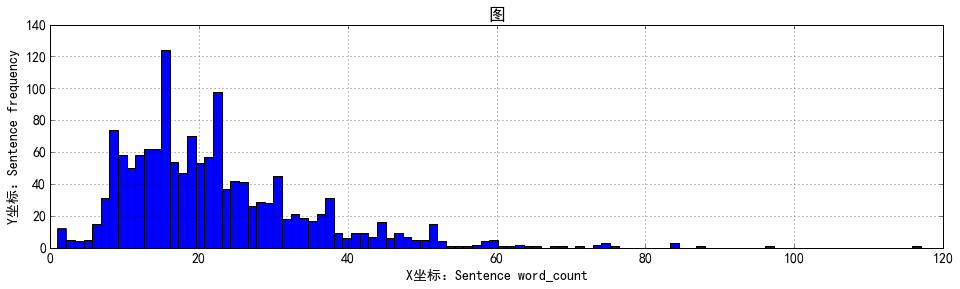

In [321]:
# 图表显示：
plt.figure(figsize=(16, 4))
plt.title(u'图')  
plt.xlabel(u'X坐标：Sentence word_count')  
plt.ylabel(u'Y坐标：Sentence frequency')  
# df_article['word_count'].value_counts().sort_values(ascending=False).plot(kind='bar', color='green')
df_article['word_count'].hist(bins=100)
# plt.gca().invert_yaxis()
plt.show()


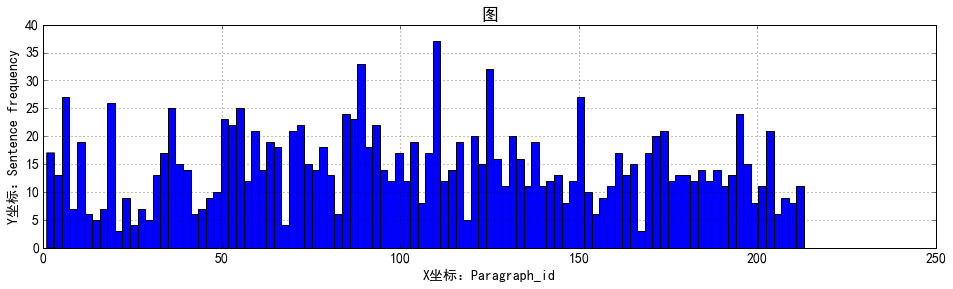

In [320]:
# 图表显示：
plt.figure(figsize=(16, 4))
plt.title(u'图')  
plt.xlabel(u'X坐标：Paragraph_id')  
plt.ylabel(u'Y坐标：Sentence frequency')  
df_article['paragraph_id'].hist(bins=100)
# plt.gca().invert_yaxis()
plt.show()


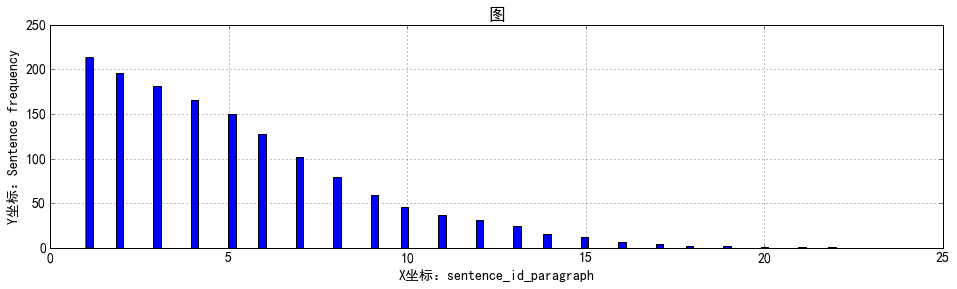

In [322]:
# 图表显示：
plt.figure(figsize=(16, 4))
plt.title(u'图')  
plt.xlabel(u'X坐标：sentence_id_paragraph')  
plt.ylabel(u'Y坐标：Sentence frequency')  
df_article['sentence_id_paragraph'].hist(bins=100)
# plt.gca().invert_yaxis()
plt.show()


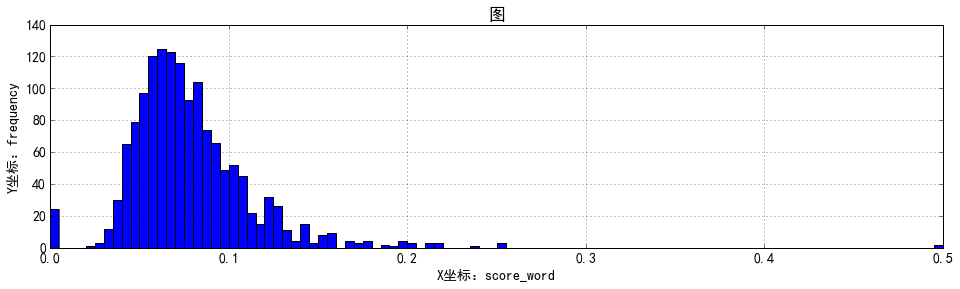

In [323]:
# 图表显示：
plt.figure(figsize=(16, 4))
plt.title(u'图')  
plt.xlabel(u'X坐标：score_word')  
plt.ylabel(u'Y坐标：frequency')  
df_article['score_word'].hist(bins = 100)
# plt.xscale('log')
# plt.yscale('log')
#plt.xlim(0,0.5)
#plt.ylim(0,0.5)
# plt.gca().invert_yaxis()
plt.show()


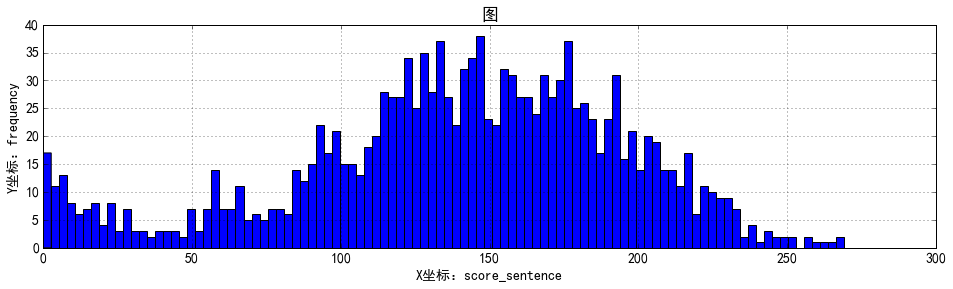

In [325]:
# 图表显示：
plt.figure(figsize=(16, 4))
plt.title(u'图')  
plt.xlabel(u'X坐标：score_sentence')  
plt.ylabel(u'Y坐标：frequency')  
df_article['score_sentence'].hist(bins = 100)
# plt.xscale('log')
# plt.yscale('log')
#plt.xlim(0,0.5)
#plt.ylim(0,0.5)
# plt.gca().invert_yaxis()
plt.show()


In [310]:
# df_article[(df_article['score_word'] > 0.15) & (df_article['score_word'] < 0.25)]
# df_article[(df_article['score_word'] > 0.2)].sort_values(by=['score_sentence', 'score_word'], ascending=[False, False,])
# df_article[(df_article['score_sentence'] > 250)].sort_values(by=['score_word', 'score_sentence'], ascending=[False, False,])


### Score Normalization

In [301]:
# log(score_word)
df_article['score_word_log'] = np.log(df_article['score_word'].astype('float64') + 
                                      df_article[df_article['score_word'] >0 ]['score_word'].min()/2)


In [330]:
# Normalize score_word_log

# df_article['score_word_norm'] = (df_article['score_word'] - df_article['score_word'].mean()) / df_article['score_word'].std()
df_article['score_word_norm'] = (df_article['score_word_log'] - df_article['score_word_log'].mean()) / df_article['score_word_log'].std()

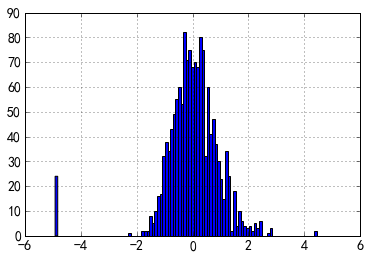

In [331]:
df_article['score_word_norm'].hist(bins=100)

In [328]:
# Normalize score_sentence

df_article['score_sentence_norm'] = (df_article['score_sentence'] - df_article['score_sentence'].mean()) / df_article['score_sentence'].std()

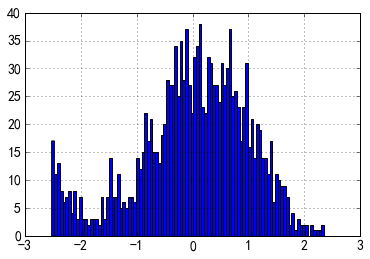

In [329]:
df_article['score_sentence_norm'].hist(bins=100)

### Generate class_rank

In [337]:
# Score integration
# df_article['score'] = (df_article['score_sentence_norm'] + df_article['score_word_norm']) / 2

# Sam Gu: 23 Mar 2017 - Experiment found that the score_word, which is based on tf-idf, doesn't seem to work well.
#                       Hence, here we use score_sentence only for final scoring.

df_article['score'] = df_article['score_sentence_norm']

In [342]:
# Min-Max normalization:
df_article['score'] = (df_article['score'] - df_article['score'].min()) / (df_article['score'].max() -df_article['score'].min())

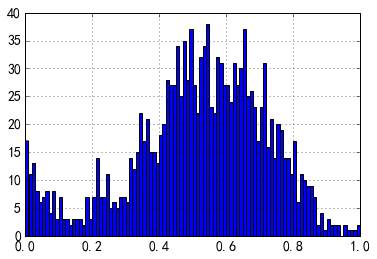

In [343]:
df_article['score'].hist(bins=100)

In [344]:
# sort firstly
df_article = df_article.sort_values(by=['paragraph_id', 'score'], ascending=[True, False]).reset_index(drop=True)

In [352]:
# Generate Class_Rank

current_class_rank = 0
current_paragraph_id = 0

for i in range(0, len(df_article)):
    if df_article['paragraph_id'][i] != current_paragraph_id: # change of Paragraph, thus reset class_rank
        current_class_rank = 1
        current_paragraph_id = df_article['paragraph_id'][i]
    else:
        current_class_rank = current_class_rank + 1
        
    df_article['class_rank'][i] = current_class_rank


G:\Tool_PGM\Anaconda3\lib\site-packages\ipykernel\__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [353]:
# sort Dataframe to 'result lookup mode'
df_article = df_article.sort_values(by=['class_rank', 'score', 'paragraph_id', 'sentence_id'], 
                                    ascending=[True, False, True, True]).reset_index(drop=True)

In [354]:
df_article[['sentence',
           'paragraph_id',
           'sentence_id_paragraph',
           'class_rank',
           'score',
           'sentence_tokenized'
          ]]

,sentence,paragraph_id,sentence_id_paragraph,class_rank,score,sentence_tokenized
0,她说：我什么也没有说。,35,1,1,1,她 说 我 什么 也 没有 说
1,我说，怎么了。,137,5,1,0.991391,我 说 怎么 了
2,她说，怎么，还要研究我的结构。,132,10,1,0.982462,她 说 怎么 还要 研究 我 的 结构
3,陈清扬说，她女儿已经上了大二，最近知道了我们的事，很想见我。,107,1,1,0.971001,陈 清扬 说 她 女儿 已经 上 了 大二 最近 知道 了 我们 的 事 很 想见 我
4,她说，暴露就暴露，我不怕。,115,7,1,0.969858,她 说 暴露 就 暴露 我 不怕
5,她说，做了的事就不怕交待。,103,13,1,0.951592,她 说 做 了 的 事 就 不怕 交待
6,我吻她的嘴，她没反对。,188,2,1,0.936763,我 吻 她 的 嘴 她 没 反对
7,她来的时候，我没有盼着她来。,67,3,1,0.935334,她 来 的 时候 我 没有 盼 着 她 来
8,可是她说，快，混蛋，还拧我的腿。,72,4,1,0.927596,可是 她 说 快 混蛋 还 拧 我 的 腿
9,陈清扬说，我叫人惦记上了。,78,3,1,0.926186,陈 清扬 说 我 叫 人 惦记 记上 了


In [359]:
# df_article[(df_article['score'] == 0) | (df_article['score'] == 1)]

### Extract results based on user parameters
Max number of words

% of original number of words, etc

In [370]:
df_article_display = pd.DataFrame.copy(df_article)

In [379]:
# Heuristic cleaning:
# 1.Remove sentences, which has only one valid word. 
# 2.Remove paragraph, which has only single sentence.

# 1.
df_article_display = df_article_display[df_article['sentence_tokenized'].map(len) > 1]

# 2.


In [383]:
# count number of sentences within a paragraph_ids
# This can be used to identify paragraph(s) containing only one sentence. Such paragraph may be removed from results.
df_article['paragraph_id'].value_counts()

111    22
84     19
6      17
151    17
60     16
88     16
93     16
33     15
51     15
124    15
110    15
3      15
69     14
172    14
86     14
103    13
185    13
10     13
52     13
20     13
132    13
126    13
204    13
96     13
133    12
75     12
55     12
116    12
174    12
100    12
       ..
153     2
22      2
155     2
25      2
28      2
212     2
167     2
205     2
106     2
34      2
12      2
182     2
44      2
2       1
15      1
213     1
21      1
29      1
46      1
68      1
83      1
95      1
118     1
141     1
146     1
158     1
168     1
184     1
200     1
1       1
Name: paragraph_id, dtype: int64

In [387]:
# df_article[df_article['paragraph_id'].value_counts() == 1]

df_article['paragraph_id'].value_counts() == 1


111    False
84     False
6      False
151    False
60     False
88     False
93     False
33     False
51     False
124    False
110    False
3      False
69     False
172    False
86     False
103    False
185    False
10     False
52     False
20     False
132    False
126    False
204    False
96     False
133    False
75     False
55     False
116    False
174    False
100    False
       ...  
153    False
22     False
155    False
25     False
28     False
212    False
167    False
205    False
106    False
34     False
12     False
182    False
44     False
2       True
15      True
213     True
21      True
29      True
46      True
68      True
83      True
95      True
118     True
141     True
146     True
158     True
168     True
184     True
200     True
1       True
Name: paragraph_id, dtype: bool

In [388]:
type(df_article['paragraph_id'].value_counts())

pandas.core.series.Series

In [380]:
df_article_display[df_article['sentence_tokenized'].map(len) < 2]

G:\Tool_PGM\Anaconda3\lib\site-packages\pandas\core\frame.py:1997: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


,sentence,word_count,sentence_id,sentence_id_paragraph,paragraph_id,class_rank,score_word,score_sentence,score_word_norm,score_sentence_norm,score,sentence_tokenized,sentence_tf,tfidf,score_word_log


In [282]:
# count number of sentences within a paragraph_ids
# This can be used to identify paragraph(s) containing only one sentence. Such paragraph may be removed from results.
df_article['paragraph_id'].value_counts()

111    22
84     19
6      17
151    17
60     16
88     16
93     16
33     15
51     15
124    15
110    15
3      15
69     14
172    14
86     14
103    13
185    13
10     13
52     13
20     13
132    13
126    13
204    13
96     13
133    12
75     12
55     12
116    12
174    12
100    12
       ..
153     2
22      2
155     2
25      2
28      2
212     2
167     2
205     2
106     2
34      2
12      2
182     2
44      2
2       1
15      1
213     1
21      1
29      1
46      1
68      1
83      1
95      1
118     1
141     1
146     1
158     1
168     1
184     1
200     1
1       1
Name: paragraph_id, dtype: int64

In [283]:
parm_max_word = 200
parm_max_percent = 0.15

In [284]:
df_article_display = df_article[0:30]

In [285]:
df_article_display = df_article_display.sort_values(by=['sentence_id'], ascending=[True]).reset_index(drop=True)
df_article_display[['sentence', 'paragraph_id', 'sentence_id_paragraph', 'class_rank', 'score']]

,sentence,paragraph_id,sentence_id_paragraph,class_rank,score
0,陈清扬说，我始终是一个恶棍。,14,1,1,1.02958
1,鸡巴。,24,3,1,0.969366
2,还说：我真笨。,33,14,1,1.16277
3,我说：什么道儿。,34,1,1,1.40086
4,她说：我什么也没有说。,35,1,1,1.33553
5,我的腰痛得厉害，完全不能打弯。,37,7,1,0.943075
6,虽然在夜里，我能看见很远的地方。,40,2,1,0.928024
7,我听了这话不高兴，她也发现了。,48,3,1,0.950497
8,那天晚上我没去找她，倒进了医院。,52,1,1,1.05018
9,等到我出院以后，就进了深山。,64,3,1,0.941816


In [285]:
df_article_display = df_article_display.sort_values(by=['sentence_id'], ascending=[True]).reset_index(drop=True)
df_article_display[['sentence', 'paragraph_id', 'sentence_id_paragraph', 'class_rank', 'score']]

,sentence,paragraph_id,sentence_id_paragraph,class_rank,score
0,陈清扬说，我始终是一个恶棍。,14,1,1,1.02958
1,鸡巴。,24,3,1,0.969366
2,还说：我真笨。,33,14,1,1.16277
3,我说：什么道儿。,34,1,1,1.40086
4,她说：我什么也没有说。,35,1,1,1.33553
5,我的腰痛得厉害，完全不能打弯。,37,7,1,0.943075
6,虽然在夜里，我能看见很远的地方。,40,2,1,0.928024
7,我听了这话不高兴，她也发现了。,48,3,1,0.950497
8,那天晚上我没去找她，倒进了医院。,52,1,1,1.05018
9,等到我出院以后，就进了深山。,64,3,1,0.941816


### Output results to a file

In [ ]:
'''

with io.open('output_topic_summary.txt','w',encoding='utf8') as f:
    f.write("Original Length : %s" % (len(title) + len(content)))
    f.write("\n")
    f.write("Summary  Length : %s" % len(summary))
    f.write("\n")
    f.write("Summary  Ratio  : %s %%" % (100 * (len(summary) / (len(title) + len(content)))))
    f.write("\n")
    f.write("\n")
    f.write(summary)
    f.close()
    
    '''